In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.image_analysis import *
from core.utils.basic_functions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
from torchvision import transforms
from PIL import Image
from scipy import stats
from torchvision.utils import make_grid

In [2]:
# set some paths
data_root = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data"


animal_name = "Diablito"
server_init = r"N:\PonceLab"
if animal_name == "Caos":
    save_root = os.path.join(r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results", "reconstraction_results_Caos")
if animal_name == "Diablito":
    save_root = os.path.join(r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results", "reconstraction_results_Diablito")
os.makedirs(save_root, exist_ok=True)
# Define the paths to the data
recon_exp_path = os.path.join(data_root, 'recon', f"recon_data_{animal_name}")

# List .mat files in each directory
recon_exp_files = list_mat_files(recon_exp_path)

In [3]:
# keys of the loaded data:
#'all_img_name_recon', 'all_img_name_select', 'array_inc', 'bk_resp_reocn', 'bk_resp_select', 'chan_ids_recon', 
#'chan_ids_select', 'evoke_resp_recon', 'evoke_resp_select', 'exp_i', 'gan_name', 'img_poss', 'img_size', 'masks_cell', 'num_of_thread',
#'pop_mean_call', 'pop_std_cell', 'resp_trial_col_cell', 'sampling_mods', 'score_cell_bhv2', 'score_mods', 'selc_analysis_data', 'spike_fn_recon', 'spike_fn_selec', 
#'stimuli_path_recon', 'stimuli_path_select', 'target_idx', 'target_name', 'target_resps_cell', 'unit_ids_recon', 'unit_ids_select', 'wave_form_recon'

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\utils\basic_functions.py:517: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[key] = np.array(list_keys)


Text(0.5, 1.0, 'target response')

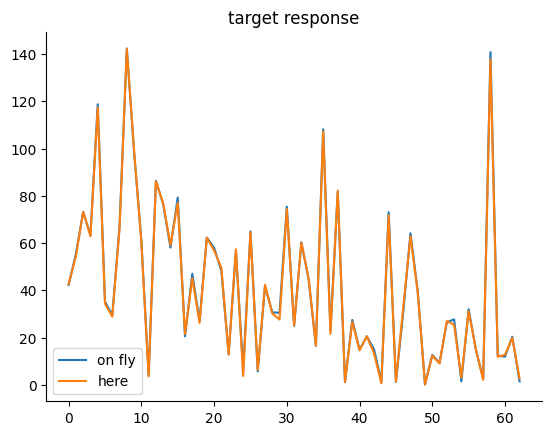

In [4]:
# for the first let seeg how diffrernt the target response when it computed on fly or here
# let's see the target response
exp_id = 1
recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_id]))
iThread = 0
target_resps_on_fly = recon_data['target_resps_cell'][iThread]
evoke_resp_select = recon_data['evoke_resp_select']
bk_resp_select = recon_data['bk_resp_select']
sub_resp = evoke_resp_select - bk_resp_select
target_img_name = recon_data['target_name'][iThread]
target_img_idx = [(target_img_name == img_name) for img_name in recon_data['all_img_name_select']]
target_resp_from_select = np.nanmean(sub_resp[:, target_img_idx],  axis=1)

unit_ids_recon_masked = recon_data['unit_ids_recon'][recon_data['masks_cell'][iThread]]
chan_ids_recon_masked = recon_data['chan_ids_recon'][recon_data['masks_cell'][iThread]]
chan_unit_recon_masked = np.stack([chan_ids_recon_masked, unit_ids_recon_masked], axis=1)
chan_unit_recon_masked = [tuple(x) for x in chan_unit_recon_masked]

# let get the mask for the response from the selectivity
unit_ids_select = recon_data['unit_ids_select']
chan_ids_select = recon_data['chan_ids_select']
chan_unit_select = np.stack([chan_ids_select, unit_ids_select], axis=1)
chan_unit_select = [tuple(x) for x in chan_unit_select]
mask_celect = np.array([x in chan_unit_recon_masked for x in chan_unit_select])
unit_ids_select_masked = unit_ids_select[mask_celect]
chan_ids_select_masked = chan_ids_select[mask_celect]


masked_target_resps_on_fly = target_resps_on_fly[recon_data['masks_cell'][iThread]]
masked_target_resps_select = target_resp_from_select[mask_celect]
# let's see the difference
plt.figure()
plt.plot(masked_target_resps_on_fly, label='on fly')
plt.plot(masked_target_resps_select, label='here')
plt.legend()
plt.title('target response')

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)


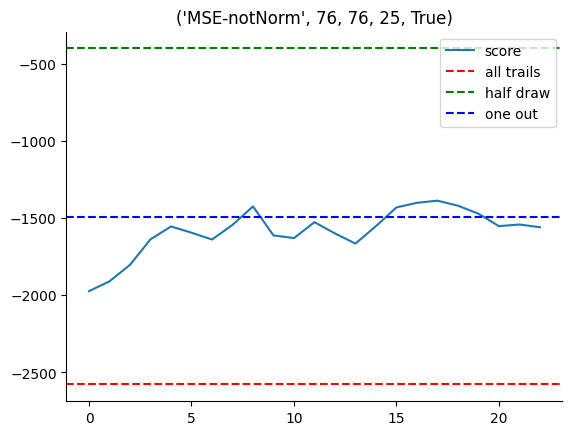

In [5]:
exp_id = 25
recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_id]))
avg_strip = 2
recon_data
iThread = 0
is_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen = process_gen_image_strings(recon_data['all_img_name_recon'])
thread_mask = (thread_ids == iThread)
sub_resp = recon_data['evoke_resp_recon'] - recon_data['bk_resp_reocn']
#score_vec = get_score_from_array(gen_resp_array, target_resp_vec, mask_vec, score_mode, popu_mean, popu_std):
score_vec = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread], recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
score_means, score_stds, score_sems, score_gens = analyze_by_gen(score_vec[thread_mask], gen_ids[thread_mask])
score_from_bhv =np.array([np.nanmean(x) for x in recon_data['score_cell_bhv2']])
# let replace score of each gen (except the first one) with the mean of the previous gens
score_gens_smooth = score_means.copy()
for i in range(1, len(score_means)):
    score_gens_smooth[i] = np.nanmean(score_means[i-avg_strip+1:i+1])
best_gen = int(score_gens[np.argmax(score_gens_smooth)])
inital_gen_score = score_vec[thread_mask & (gen_ids == 0)]
best_gen_score = score_vec[thread_mask & ((gen_ids == best_gen) | (gen_ids == best_gen-1))] 
# let get the score for 
# let's find the noise ceiling
evoke_resp_select = recon_data['evoke_resp_select']
bk_resp_select = recon_data['bk_resp_select']
sub_resp_select = evoke_resp_select - bk_resp_select
target_img_name = recon_data['target_name'][iThread]
target_img_idx = [(target_img_name == img_name) for img_name in recon_data['all_img_name_select']]
target_resp_from_mat = sub_resp_select[:, target_img_idx]
unit_ids_select = recon_data['unit_ids_select']
unit_ids_recon = recon_data['unit_ids_recon']
select_mask = get_selectivity_exp_coresponded_mask(recon_data, iThread)
all_trails_noise, half_draw_noise, one_out_noise = get_target_noise_celling(
        target_resp_from_mat, select_mask, recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread], diff_mask= True, second_mask = recon_data['masks_cell'][iThread])

# let's tun the rank sum test (wilcoxon) one sided to see if the best gen is better than the initial gen
_, p_val = stats.ranksums(inital_gen_score, best_gen_score, alternative='less')
# let's see the score 
plt.figure()
#plt.plot(score_from_bhv, label='from bhv')
plt.plot(score_gens_smooth, label='score')
# add celling lines
plt.axhline(np.nanmean(np.concatenate(all_trails_noise)), color='r', linestyle='--', label='all trails')
plt.axhline(np.nanmean(half_draw_noise), color='g', linestyle='--', label='half draw')
plt.axhline(np.nanmean(one_out_noise), color='b', linestyle='--', label='one out')
plt.legend()
plt.title((recon_data['score_mods'][iThread], len(unit_ids_recon), len(unit_ids_select), exp_id, p_val<0.05))
plt.show()



In [6]:
# let get the summary of the score results which is contin the score for each thread, initial gen, best gen, noise ceiling and p_val and some info for the recon data
# such as file_name, exp_name, masking condition, score_mode, sampling_mode, ...

avg_strip = 2
file_name_patern = r'^(.*?)_expId(\d{3}).mat$'

score_data_pd = pd.DataFrame(columns= ['exp_name', 'exp_i', 'exp_id', 'file_name', 'thread_id', 'score_mode', 'array_inc', 'sampling_mode', 'img_poss', 'img_size', 'score_from_bhv', 
                                       'score_means_smooth', 'score_means', 'score_stds', 'score_sems', 'score_gens', 'best_gen', 'inital_gen_score', 'best_gen_score', 'score_means_MSE', 'score_stds_MSE', 
                                       'score_sems_MSE', 'score_gens_MSE', 'score_means_smooth_MSE', 'best_gen_MSE', 'inital_gen_score_MSE', 'best_gen_score_MSE', 
                                       'p_val', 'p_val_MSE', 'noise_ceiling_all_trails', 'noise_ceiling_half_draw', 'noise_ceiling_one_out', 'noise_ceiling_all_trails_MSE', 'noise_ceiling_half_draw_MSE', 'noise_ceiling_one_out_MSE',
                                       'target_resp', 'best_gen_resp_mean', 'best_gen_resp_sem', 'ini_resp_mean', 'ini_resp_sem', 'score_means_smooth_SEM',
                                        'hand_chose_mask_flag', 'use_responsive_mask', 'use_selective_mask', 'exp_date'])
                             
for exp_i in range(len(recon_exp_files)):
    file_name = recon_exp_files[exp_i] 
    matches = re.match(file_name_patern, file_name)
    exp_name, expriment_id = matches.groups()
    expriment_id = int(expriment_id)
    exp_date = exp_name.split('-')[1]
    exp_datetime_obj = parse_date(exp_date, animal_name)

    recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_i]))
    nun_of_thread = int(recon_data['num_of_thread'])

    for iThread in range(nun_of_thread):
        is_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen = process_gen_image_strings(recon_data['all_img_name_recon'])
        thread_mask = (thread_ids == iThread)
        sub_resp = recon_data['evoke_resp_recon'] - recon_data['bk_resp_reocn']
        
        target_resp = recon_data['target_resps_cell'][iThread]
        total_mean = recon_data['pop_mean_call'][iThread]
        total_std = recon_data['pop_std_cell'][iThread]
        target_resp = (target_resp- total_mean) / total_std
        sub_resp_norm = (sub_resp - total_mean[:, None]) / total_std[:, None]
        resp_mean, resp_std, resp_sem, resp_uique_gen = analyze_by_gen(sub_resp_norm[:, thread_mask], gen_ids[thread_mask])

        resp_mean = resp_mean[recon_data['masks_cell'][iThread]]
        resp_std = resp_std[recon_data['masks_cell'][iThread]]
        resp_sem = resp_sem[recon_data['masks_cell'][iThread]]
        target_resp = target_resp[recon_data['masks_cell'][iThread]]
        

        this_thread_imgs = recon_data['all_img_name_recon'][thread_mask]
        score_vec = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread], recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
        score_means, score_stds, score_sems, score_gens = analyze_by_gen(score_vec[thread_mask], gen_ids[thread_mask])
        score_from_bhv =np.array([np.nanmean(x) for x in recon_data['score_cell_bhv2']])
        # let replace score of each gen (except the first one) with the mean of the previous gens
        score_means_smooth = score_means.copy()
        for i in range(1, len(score_means)):
            score_means_smooth[i] = np.nanmean(score_means[i-avg_strip+1:i+1])
        best_gen = int(score_gens[np.argmax(score_means_smooth)])
        inital_gen_score = score_vec[thread_mask & (gen_ids == 0)]
        best_gen_score = score_vec[thread_mask & (gen_ids == best_gen)] # score_vec[thread_mask & ((gen_ids == best_gen) | (gen_ids == best_gen-1))] #TODO ASK THIS

        best_gen_resp_mean = resp_mean[:, resp_uique_gen == best_gen]
        best_gen_resp_sem = resp_sem[:, resp_uique_gen == best_gen]

        ini_resp_mean = resp_mean[:, resp_uique_gen == 0]
        ini_resp_sem = resp_sem[:, resp_uique_gen == 0]

        # let's find the noise ceiling
        evoke_resp_select = recon_data['evoke_resp_select']
        bk_resp_select = recon_data['bk_resp_select']
        sub_resp_select = evoke_resp_select - bk_resp_select
        target_img_name = recon_data['target_name'][iThread]
        target_img_idx = [(target_img_name == img_name) for img_name in recon_data['all_img_name_select']]
        target_resp_from_mat = sub_resp_select[:, target_img_idx]
        unit_ids_select = recon_data['unit_ids_select']
        unit_ids_recon = recon_data['unit_ids_recon']
        select_mask = get_selectivity_exp_coresponded_mask(recon_data, iThread)
        all_trails_noise, half_draw_noise, one_out_noise = get_target_noise_celling(
                target_resp_from_mat, select_mask, recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread], diff_mask= True, second_mask = recon_data['masks_cell'][iThread]) 
        # let's tun the rank sum test (wilcoxon) one sided to see if the best gen is better than the initial gen
        _, p_val = stats.ranksums(inital_gen_score, best_gen_score, alternative='less') 

        # let here have get score with MSE no matter what the score mode is
        # let's get the MSE score
        score_vec_MSE = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread], 'MSE', recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
        score_means_MSE, score_stds_MSE, score_sems_MSE, score_gens_MSE = analyze_by_gen(score_vec_MSE[thread_mask], gen_ids[thread_mask])
        score_means_smooth_MSE = score_means_MSE.copy()
        score_means_smooth_SEM = score_means_MSE.copy()
        for i in range(1, len(score_means_MSE)):
            score_means_smooth_MSE[i] = np.nanmean(score_means_MSE[i-avg_strip+1:i+1])
            score_means_smooth_SEM[i] = np.nanstd(score_sems_MSE[i-avg_strip+1:i+1])
        best_gen_MSE = int(score_gens_MSE[np.argmax(score_means_smooth_MSE)])
        inital_gen_score_MSE = score_vec_MSE[thread_mask & (gen_ids == 0)]
        best_gen_score_MSE = score_vec_MSE[thread_mask & ((gen_ids == best_gen_MSE))] # score_vec_MSE[thread_mask & ((gen_ids == best_gen_MSE) | (gen_ids == best_gen_MSE-1))] #TODO ASK THIS
        # let's tun the rank sum test (wilcoxon) one sided to see if the best gen is better than the initial gen
        _, p_val_MSE = stats.ranksums(inital_gen_score_MSE, best_gen_score_MSE, alternative='less')

        all_trails_noise_MSE, half_draw_noise_MSE, one_out_noise_MSE = get_target_noise_celling(
                target_resp_from_mat, select_mask, 'MSE', recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread], diff_mask= True, second_mask = recon_data['masks_cell'][iThread])
    

        data_pd = pd.DataFrame({'exp_name': exp_name, 'exp_i': exp_i,  'exp_id': expriment_id, 'file_name': file_name, 'thread_id': iThread,
                'score_mode': recon_data['score_mods'][iThread], 'array_inc': [recon_data['array_inc'][iThread]],
                'sampling_mode': recon_data['sampling_mods'][iThread], 'img_poss': [recon_data['img_poss'][iThread]], 'img_size': recon_data['img_size'][iThread], 
                'score_from_bhv': [score_from_bhv], 'score_means_smooth': [score_means_smooth], 'score_means': [score_means], 'score_stds': [score_stds], 'score_sems': [score_sems], 'score_gens': [score_gens], 
                'best_gen': [best_gen], 'inital_gen_score': [inital_gen_score], 'best_gen_score': [best_gen_score],
                'score_means_MSE': [score_means_MSE], 'score_stds_MSE': [score_stds_MSE], 'score_sems_MSE': [score_sems_MSE], 'score_gens_MSE': [score_gens_MSE], 'score_means_smooth_MSE': [score_means_smooth_MSE],
                'best_gen_MSE': [best_gen_MSE], 'inital_gen_score_MSE': [inital_gen_score_MSE], 'best_gen_score_MSE': [best_gen_score_MSE], 'p_val': p_val, 'p_val_MSE': p_val_MSE,
                'noise_ceiling_all_trails': [all_trails_noise], 'noise_ceiling_half_draw': [half_draw_noise], 'noise_ceiling_one_out': [one_out_noise],
                'noise_ceiling_all_trails_MSE': [all_trails_noise_MSE], 'noise_ceiling_half_draw_MSE': [half_draw_noise_MSE], 'noise_ceiling_one_out_MSE': [one_out_noise_MSE],
                'score_means_smooth_SEM': [score_means_smooth_SEM],
                'target_resp': [target_resp], 'best_gen_resp_mean': [best_gen_resp_mean], 'best_gen_resp_sem': [best_gen_resp_sem], 'ini_resp_mean': [ini_resp_mean], 'ini_resp_sem': [ini_resp_sem],
                'hand_chose_mask_flag': recon_data['hand_chose_mask_flag'], 'use_responsive_mask': recon_data['use_responsive_mask'], 'use_selective_mask': recon_data['use_selective_mask'], 'exp_date': exp_datetime_obj})
        
        score_data_pd = pd.concat([score_data_pd, data_pd])
score_data_pd.reset_index(inplace=True)
score_data_pd['array_inc_open'] = [x[0] for x in score_data_pd['array_inc']]



ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\utils\basic_functions.py:517: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[key] = np.array(list_keys)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\utils\basic_functions.py:124: RuntimeWarning: Mean of empty slice
  gen_means[:, i] = np.nanmean(gen_values, axis=1)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (

In [7]:
# 
# let plot the score for all exps
# let filler all taht sampling_mode is 'all', use responsive mask is 1 and array_inc is ['V1, V4, IT']
save_path = os.path.join(save_root, 'score_plot_with_noise_ceiling')
os.makedirs(save_path, exist_ok=True)

init_mask = (score_data_pd['sampling_mode'] == 'all') & (score_data_pd['use_responsive_mask'] == 1) & (score_data_pd['array_inc_open'] == 'V1, V4, IT')
MSE_mask = (score_data_pd['score_mode'] == 'MSE') & init_mask
MSE_notNorm_mask = (score_data_pd['score_mode'] == 'MSE-notNorm') & init_mask
cosine_mask = (score_data_pd['score_mode'] == 'cosine') & init_mask

full_mask = (MSE_notNorm_mask |MSE_mask) & init_mask

score_data_sub_df = score_data_pd[full_mask]

for row_id in range(len(score_data_sub_df)):
    score_means_smooth_MSE = score_data_sub_df['score_means_smooth_MSE'].iloc[row_id]
    score_means_smooth_MSE_SEM = score_data_sub_df['score_means_smooth_SEM'].iloc[row_id]
    score_means_smooth_MSE_SEM[0] = 0
    one_out_noise_MSE = score_data_sub_df['noise_ceiling_one_out_MSE'].iloc[row_id]
    score_gens_MSE = score_data_sub_df['score_gens_MSE'].iloc[row_id]
    score_gens_MSE = score_data_sub_df['score_gens'].iloc[row_id]
    # let get nice seboran color
    colors = sns.color_palette("tab10", 4)

    fig, ax = plt.subplots(figsize=(5,3.5))
    ax.errorbar(score_gens_MSE, score_means_smooth_MSE, yerr=score_means_smooth_MSE_SEM, color='k', label='MSE', linewidth=1.5)
    # let add the shade for the noise ceiling
    ax.tick_params(axis='both', which='major', labelsize=18)
    # let add the axis labels 
    font_size = 20
    ax.set_xlabel('generation #', fontsize=font_size)
    ax.set_ylabel('MSE', fontsize=font_size)
    # just keep 5 vales for both x and y ticks
    ax.locator_params(nbins=5)
    # change both axix line whidth to 1.25
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['left'].set_linewidth(1.25)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{score_data_sub_df['exp_name'].iloc[row_id]}_expId{score_data_sub_df['exp_id'].iloc[row_id]}_thread{score_data_sub_df['thread_id'].iloc[row_id]}.png"))
    plt.savefig(os.path.join(save_path, f"{score_data_sub_df['exp_name'].iloc[row_id]}_expId{score_data_sub_df['exp_id'].iloc[row_id]}_thread{score_data_sub_df['thread_id'].iloc[row_id]}.pdf"), format='pdf')
  
    plt.close()

    # let plot the score_means_smooth_MSE
    fig, ax = plt.subplots(figsize=(5,3.5))
    ax.errorbar(score_gens_MSE, score_means_smooth_MSE, yerr=score_means_smooth_MSE_SEM, color='k', label='MSE', linewidth=1.5)
    # let add the shade for the noise ceiling
    ax.fill_between([0, np.max(score_gens_MSE)], np.nanmean(score_means_smooth_MSE) - np.nanstd(score_means_smooth_MSE),  np.nanmean(score_means_smooth_MSE)+np.nanstd(score_means_smooth_MSE), color=colors[0], alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=18)
    # let add the axis labels 
    font_size = 20
    ax.set_xlabel('generation #', fontsize=font_size)
    ax.set_ylabel('MSE', fontsize=font_size)
    # just keep 5 vales for both x and y ticks
    ax.locator_params(nbins=5)
    # change both axix line whidth to 1.25
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['left'].set_linewidth(1.25)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{score_data_sub_df['exp_name'].iloc[row_id]}_expId{score_data_sub_df['exp_id'].iloc[row_id]}_thread{score_data_sub_df['thread_id'].iloc[row_id]}_with_celling.png"))
    plt.savefig(os.path.join(save_path, f"{score_data_sub_df['exp_name'].iloc[row_id]}_expId{score_data_sub_df['exp_id'].iloc[row_id]}_thread{score_data_sub_df['thread_id'].iloc[row_id]}_with_celling.pdf"), format='pdf')
    plt.close()

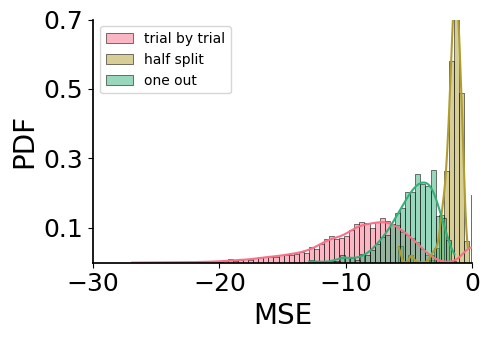

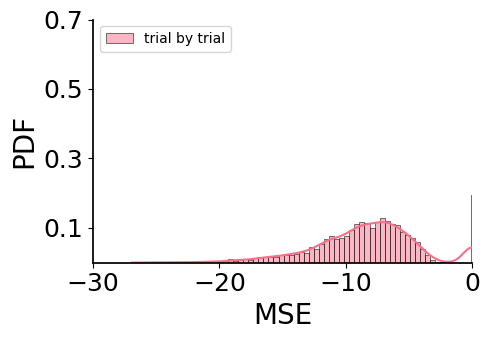

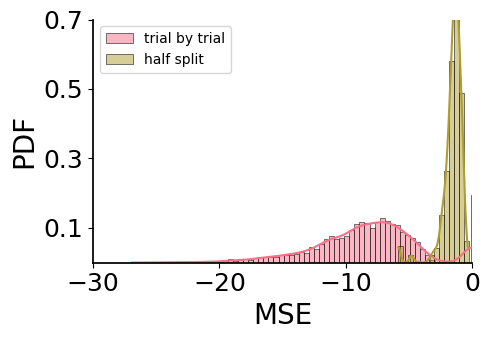

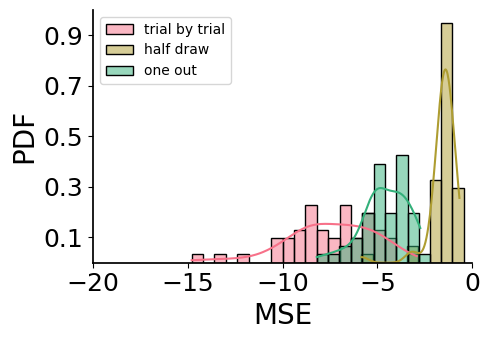

In [8]:
# let filler all taht sampling_mode is 'all', use responsive mask is 1 and array_inc is ['V1, V4, IT']
init_mask = (score_data_pd['sampling_mode'] == 'all') & (score_data_pd['use_responsive_mask'] == 1) & (score_data_pd['array_inc_open'] == 'V1, V4, IT') 
alpha_val = 0.01
MSE_mask = (score_data_pd['score_mode'] == 'MSE') & init_mask
MSE_notNorm_mask = (score_data_pd['score_mode'] == 'MSE-notNorm') & init_mask
cosine_mask = (score_data_pd['score_mode'] == 'cosine') & init_mask

full_mask = MSE_mask & init_mask

# let get distribution of different noise ceiling
trial_by_trial_ceiling = np.concatenate([np.concatenate(x) for x in score_data_pd['noise_ceiling_all_trails'][full_mask]])
trial_by_trial_ceiling_mean = np.array([np.nanmean(np.concatenate(x)) for x in score_data_pd['noise_ceiling_all_trails'][full_mask]])
half_draw_ceiling = np.concatenate(score_data_pd['noise_ceiling_half_draw'][full_mask].values)
half_draw_ceiling_mean = np.array([np.nanmean(x) for x in score_data_pd['noise_ceiling_half_draw'][full_mask]])
one_out_ceiling = np.concatenate(score_data_pd['noise_ceiling_one_out'][full_mask].values)
one_out_ceiling_mean = np.array([np.nanmean(x) for x in score_data_pd['noise_ceiling_one_out'][full_mask]])

# let get p_val for score improvement
p_val = np.array(score_data_pd['p_val'][full_mask])
p_val_flag = p_val < alpha_val

trial_by_trial_ceiling_mean[trial_by_trial_ceiling_mean == -np.inf] = np.nan
half_draw_ceiling_mean[half_draw_ceiling_mean == -np.inf] = np.nan
one_out_ceiling_mean[one_out_ceiling_mean == -np.inf] = np.nan
# let get thee distingushable colors form seaborn
colors = sns.color_palette('husl', 5)

# let plot the distribution of the noise ceiling and normailized the distribution to get PDf
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.histplot(trial_by_trial_ceiling, color=colors[0], label='trial by trial', kde=True , stat='density', binwidth=0.4)
sns.histplot(half_draw_ceiling, color=colors[1], label='half split', kde=True, stat='density', binwidth=0.4)
sns.histplot(one_out_ceiling, color=colors[2], label='one out', kde=True, stat='density', binwidth=0.4)
plt.xlabel('MSE', fontsize=20)
plt.ylabel('PDF', fontsize=20)
ax.locator_params(nbins=4)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_yticks([.1, .3, .5, .7])
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# set xlim to -30 to 0
ax.set_ylim([0, .7])
ax.set_xlim(-30, 0)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'noise_ceiling_dist_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'noise_ceiling_dist_all.pdf'), format='pdf')

fig, ax = plt.subplots(figsize=(5, 3.5))
sns.histplot(trial_by_trial_ceiling, color=colors[0], label='trial by trial', kde=True , stat='density', binwidth=0.4)
plt.xlabel('MSE', fontsize=20)
plt.ylabel('PDF', fontsize=20)
ax.locator_params(nbins=4)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_yticks([.1, .3, .5, .7])
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# set xlim to -30 to 0
ax.set_ylim([0, .7])
ax.set_xlim(-30, 0)
# add legend to top left
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'noise_ceiling_dist_t.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'noise_ceiling_dist_t.pdf'), format='pdf')


fig, ax = plt.subplots(figsize=(5, 3.5))
sns.histplot(trial_by_trial_ceiling, color=colors[0], label='trial by trial', kde=True , stat='density', binwidth=0.4)
sns.histplot(half_draw_ceiling, color=colors[1], label='half split', kde=True, stat='density', binwidth=0.4)
plt.xlabel('MSE', fontsize=20)
plt.ylabel('PDF', fontsize=20)
ax.locator_params(nbins=4)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_yticks([.1, .3, .5, .7])
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# set xlim to -30 to 0
ax.set_ylim([0, .7])
ax.set_xlim(-30, 0)
# add legend to top left
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'noise_ceiling_dist_th.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'noise_ceiling_dist_th.pdf'), format='pdf')



fig, ax = plt.subplots(figsize=(5, 3.5))
sns.histplot(trial_by_trial_ceiling_mean, color=colors[0], label='trial by trial', kde=True , stat='density', binwidth=0.6)
sns.histplot(half_draw_ceiling_mean, color=colors[1], label='half draw', kde=True, stat='density', binwidth=0.6)
sns.histplot(one_out_ceiling_mean, color=colors[2], label='one out', kde=True, stat='density', binwidth=0.6)
plt.xlabel('MSE')
# set xlim to -30 to 0
plt.xlabel('MSE', fontsize=20)
plt.ylabel('PDF', fontsize=20)
ax.locator_params(nbins=4)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_yticks([.1, .3, .5, .7, .9]) 
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# set xlim to -30 to 0
ax.set_ylim([0, 1])
ax.set_xlim(-20, 0)
# add legend to top left
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'noise_ceiling_dist_of_means.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'noise_ceiling_dist_of_means.pdf'), format='pdf')


Percentage of significant improvement: 35.29%


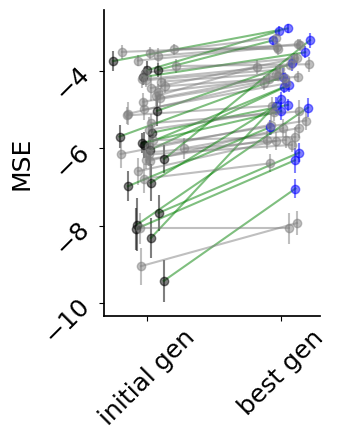

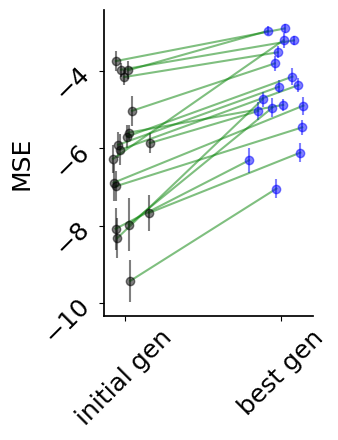

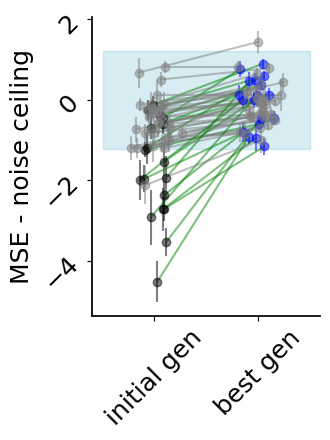

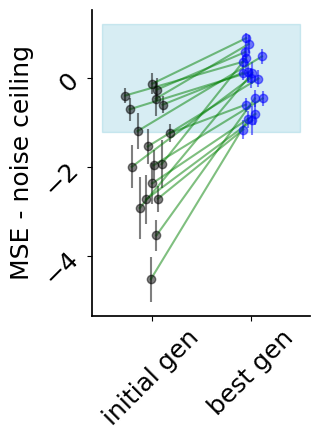

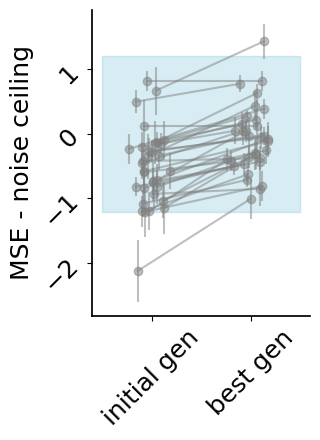

In [9]:
#
# let get initial gen score and best gen score avrage and sem the all rows masked
save_path = os.path.join(save_root, 'score_init_vs_last_with_noise_ceiling')
os.makedirs(save_path, exist_ok=True)
inital_gen_score_mean = np.array([np.nanmean(x) for x in score_data_pd['inital_gen_score'][full_mask]])
best_gen_score_mean = np.array([np.nanmean(x) for x in score_data_pd['best_gen_score'][full_mask]])
inital_gen_score_sem = np.array([stats.sem(x, nan_policy='omit') for x in score_data_pd['inital_gen_score'][full_mask]])
best_gen_score_sem = np.array([stats.sem(x, nan_policy='omit') for x in score_data_pd['best_gen_score'][full_mask]])
colors = sns.color_palette("tab10", 4)
colors_noise = sns.color_palette('husl', 5)

font_size = 18

p_val = np.array(score_data_pd['p_val'][full_mask])
p_val_flag = p_val < .01
fig, ax = plt.subplots(1, 1, figsize=(3.4, 4.5))
x_for_inital = np.random.normal(1, 0.1, len(inital_gen_score_mean))
x_for_best = np.random.normal(2, 0.1, len(best_gen_score_mean))
ax.errorbar(x_for_inital[p_val_flag], inital_gen_score_mean[p_val_flag], yerr=inital_gen_score_sem[p_val_flag], fmt='o', label='initial gen', color='k', alpha=0.5)
ax.errorbar(x_for_inital[~p_val_flag], inital_gen_score_mean[~p_val_flag], yerr=inital_gen_score_sem[~p_val_flag], fmt='o', label='initial gen', color='gray', alpha=0.5)
ax.errorbar(x_for_best[p_val_flag], best_gen_score_mean[p_val_flag], yerr=best_gen_score_sem[p_val_flag], fmt='o', label='best gen', alpha=0.5, color='b')
ax.errorbar(x_for_best[~p_val_flag], best_gen_score_mean[~p_val_flag], yerr=best_gen_score_sem[~p_val_flag], fmt='o', label='best gen', alpha=0.5, color='gray')
# let connect the dots by line

for i in range(len(inital_gen_score_mean)):
    if p_val_flag[i]:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i], best_gen_score_mean[i]], color='green', alpha=0.5)
    else:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i], best_gen_score_mean[i]], color='gray', alpha=0.5)
# let add a rectangle to show the noise ceiling
#ax.axhline(np.nanmean(trial_by_trial_ceiling_mean), color=colors_noise[0], label='trial by trial', linestyle= '--')
#ax.axhline(np.nanmean(half_draw_ceiling_mean), color=colors_noise[1], linestyle='--', label='half draw')
#ax.axhline(np.nanmean(one_out_ceiling_mean), color=colors_noise[3], linestyle='--', label='one out')
#ax.fill_between([0.5, 2.5], np.nanmean(one_out_ceiling_mean) - np.nanstd(one_out_ceiling_mean), np.nanmean(one_out_ceiling_mean) + np.nanstd(one_out_ceiling_mean), color=colors_noise[3], alpha=0.2)
ax.set_xticks([1, 2], ['initial gen', 'best gen'])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel('MSE', fontsize=font_size)
# just keep 5 vales for both x and y ticks
ax.locator_params(nbins=5)
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# rotate the x ticks and y ticks
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
# let subtracet the noise ceiling from the score
plt.savefig(os.path.join(save_path, 'score_init_vs_last_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'score_init_vs_last_all.pdf'), format='pdf')

fig, ax = plt.subplots(1, 1, figsize=(3.4, 4.5))
x_for_inital = np.random.normal(1, 0.1, len(inital_gen_score_mean))
x_for_best = np.random.normal(2, 0.1, len(best_gen_score_mean))
ax.errorbar(x_for_inital[p_val_flag], inital_gen_score_mean[p_val_flag], yerr=inital_gen_score_sem[p_val_flag], fmt='o', label='initial gen', color='k', alpha=0.5)
ax.errorbar(x_for_best[p_val_flag], best_gen_score_mean[p_val_flag], yerr=best_gen_score_sem[p_val_flag], fmt='o', label='best gen', alpha=0.5, color='b')
# let connect the dots by line

for i in range(len(inital_gen_score_mean)):
    if p_val_flag[i]:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i], best_gen_score_mean[i]], color='green', alpha=0.5)
# let add a rectangle to show the noise ceiling
ax.set_xticks([1, 2], ['initial gen', 'best gen'])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel('MSE', fontsize=font_size)
# just keep 5 vales for both x and y ticks
ax.locator_params(nbins=5)
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# rotate the x ticks and y ticks
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
# let subtracet the noise ceiling from the score
plt.savefig(os.path.join(save_path, 'score_init_vs_last_just_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'score_init_vs_last_just_sig.pdf'), format='pdf')


fig, ax = plt.subplots(1, 1, figsize=(3.4, 4.5))
x_for_inital = np.random.normal(1, 0.1, len(inital_gen_score_mean))
x_for_best = np.random.normal(2, 0.1, len(best_gen_score_mean))
ax.errorbar(x_for_inital[p_val_flag], inital_gen_score_mean[p_val_flag]-one_out_ceiling_mean[p_val_flag], yerr=inital_gen_score_sem[p_val_flag], fmt='o', label='initial gen', color='k', alpha=0.5)
ax.errorbar(x_for_inital[~p_val_flag], inital_gen_score_mean[~p_val_flag]-one_out_ceiling_mean[~p_val_flag], yerr=inital_gen_score_sem[~p_val_flag], fmt='o', label='initial gen', color='gray', alpha=0.5)

ax.errorbar(x_for_best[p_val_flag], best_gen_score_mean[p_val_flag] -one_out_ceiling_mean[p_val_flag], yerr=best_gen_score_sem[p_val_flag], fmt='o', label='best gen', alpha=0.5, color='b')
ax.errorbar(x_for_best[~p_val_flag], best_gen_score_mean[~p_val_flag] -one_out_ceiling_mean[~p_val_flag], yerr=best_gen_score_sem[~p_val_flag], fmt='o', label='best gen', alpha=0.5, color='gray')
for i in range(len(inital_gen_score_mean)):
    if p_val_flag[i]:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i]-one_out_ceiling_mean[i], best_gen_score_mean[i]-one_out_ceiling_mean[i]], color='green', alpha=0.5)
    else:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i]-one_out_ceiling_mean[i], best_gen_score_mean[i]-one_out_ceiling_mean[i]], color='gray', alpha=0.5)

        
plt.fill_between([0.5, 2.5], - np.nanstd(one_out_ceiling_mean),  np.nanstd(one_out_ceiling_mean), color=colors_noise[3], alpha=0.2)
ax.set_xticks([1, 2], ['initial gen', 'best gen'])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel('MSE - noise ceiling', fontsize=font_size)
# just keep 5 vales for both x and y ticks
ax.locator_params(nbins=5)
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# rotate the x ticks and y ticks
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'score_init_vs_last_one_outnoise_ceiling_centeread_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'score_init_vs_last_one_outnoise_ceiling_centeread_all.pdf'), format='pdf')



fig, ax = plt.subplots(1, 1, figsize=(3.3, 4.5))
x_for_inital = np.random.normal(1, 0.1, len(inital_gen_score_mean))
x_for_best = np.random.normal(2, 0.1, len(best_gen_score_mean))
plt.errorbar(x_for_inital[p_val_flag],  inital_gen_score_mean[p_val_flag] -one_out_ceiling_mean[p_val_flag], yerr=inital_gen_score_sem[p_val_flag], fmt='o', label='initial gen', color='k', alpha=0.5)
plt.errorbar(x_for_best[p_val_flag], best_gen_score_mean[p_val_flag] -one_out_ceiling_mean[p_val_flag], yerr=best_gen_score_sem[p_val_flag], fmt='o', label='best gen', alpha=0.5, color='b')
for i in range(len(inital_gen_score_mean)):
    if p_val_flag[i]:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i]-one_out_ceiling_mean[i], best_gen_score_mean[i]-one_out_ceiling_mean[i]], color='green', alpha=0.5)

plt.fill_between([0.5, 2.5], - np.nanstd(one_out_ceiling_mean),  np.nanstd(one_out_ceiling_mean), color=colors_noise[3], alpha=0.2)
ax.set_xticks([1, 2], ['initial gen', 'best gen'])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel('MSE - noise ceiling', fontsize=font_size)
# just keep 5 vales for both x and y ticks
ax.locator_params(nbins=5)
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# rotate the x ticks and y ticks
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'score_init_vs_last_one_outnoise_ceiling_centeread_just_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'score_init_vs_last_one_outnoise_ceiling_centeread_just_sig.pdf'), format='pdf')


fig, ax = plt.subplots(1, 1, figsize=(3.3, 4.5))
x_for_inital = np.random.normal(1, 0.1, len(inital_gen_score_mean))
x_for_best = np.random.normal(2, 0.1, len(best_gen_score_mean))
plt.errorbar(x_for_inital[~p_val_flag],  inital_gen_score_mean[~p_val_flag] -one_out_ceiling_mean[~p_val_flag], yerr=inital_gen_score_sem[~p_val_flag], fmt='o', label='initial gen', color='gray', alpha=0.5)
plt.errorbar(x_for_best[~p_val_flag], best_gen_score_mean[~p_val_flag] -one_out_ceiling_mean[~p_val_flag], yerr=best_gen_score_sem[~p_val_flag], fmt='o', label='best gen', alpha=0.5, color='gray')
for i in range(len(inital_gen_score_mean)):
    if ~p_val_flag[i]:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i]-one_out_ceiling_mean[i], best_gen_score_mean[i]-one_out_ceiling_mean[i]], color='gray', alpha=0.5)

plt.fill_between([0.5, 2.5], - np.nanstd(one_out_ceiling_mean),  np.nanstd(one_out_ceiling_mean), color=colors_noise[3], alpha=0.2)
ax.set_xticks([1, 2], ['initial gen', 'best gen'])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel('MSE - noise ceiling', fontsize=font_size)
# just keep 5 vales for both x and y ticks
ax.locator_params(nbins=5)
# change both axix line whidth to 1.25
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# rotate the x ticks and y ticks
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'score_init_vs_last_one_outnoise_ceiling_centeread_just_non_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'score_init_vs_last_one_outnoise_ceiling_centeread_just_non_sig.pdf'), format='pdf')

# let print percentage of significant improvement
print(f"Percentage of significant improvement: {np.sum(p_val_flag)/len(p_val_flag)*100:.2f}%")



In [10]:
# let have all target image
save_path = os.path.join(save_root, 'target_image')
os.makedirs(save_path, exist_ok=True)
for exp_i in range(len(recon_exp_files)):
    file_name = recon_exp_files[exp_i] 
    matches = re.match(file_name_patern, recon_exp_files[exp_i])
    exp_name, expriment_id = matches.groups()
    expriment_id = int(expriment_id)

    recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_i]))
    nun_of_thread = int(recon_data['num_of_thread'])

    for iThread in range(nun_of_thread):
        stimuli_path_select = recon_data['stimuli_path_select']
        
        target_name = recon_data['target_name'][iThread]

        target_image = load_image_by_name(target_name, stimuli_path_select)
        # let save it as png by make it PLT
        target_image_plt = ToPILImage()(target_image)
        target_image_plt.save(os.path.join(save_path, f"{exp_name}_expId{expriment_id}_thread{iThread}_target.png"))


ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\utils\basic_functions.py:517: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[key] = np.array(list_keys)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)

In [11]:
# let plot the score for all exps
# let filler all taht sampling_mode is 'all', use responsive mask is 1 and array_inc is ['V1, V4, IT']
''''init_mask = (score_data_pd['sampling_mode'] == 'all') & (score_data_pd['use_responsive_mask'] == 1) & (score_data_pd['array_inc_open'] == 'V1, V4, IT')
alpha_val = 0.01
MSE_mask = (score_data_pd['score_mode'] == 'MSE') & init_mask
MSE_notNorm_mask = (score_data_pd['score_mode'] == 'MSE-notNorm') & init_mask
cosine_mask = (score_data_pd['score_mode'] == 'cosine') & init_mask

full_mask = (MSE_notNorm_mask |MSE_mask) & init_mask

# let get distribution of different noise ceiling
trial_by_trial_ceiling = np.concatenate([np.concatenate(x) for x in score_data_pd['noise_ceiling_all_trails_MSE'][full_mask]])
trial_by_trial_ceiling_mean = np.array([np.nanmean(np.concatenate(x)) for x in score_data_pd['noise_ceiling_all_trails_MSE'][full_mask]])
half_draw_ceiling = np.concatenate(score_data_pd['noise_ceiling_half_draw_MSE'][full_mask].values)
half_draw_ceiling_mean = np.array([np.nanmean(x) for x in score_data_pd['noise_ceiling_half_draw_MSE'][full_mask]])
one_out_ceiling = np.concatenate(score_data_pd['noise_ceiling_one_out_MSE'][full_mask].values)
one_out_ceiling_mean = np.array([np.nanmean(x) for x in score_data_pd['noise_ceiling_one_out_MSE'][full_mask]])

# let get p_val for score improvement
p_val = score_data_pd['p_val_MSE'][full_mask]
p_val = np.array(score_data_pd['p_val_MSE'][full_mask])
p_val_flag = p_val < alpha_val

trial_by_trial_ceiling_mean[trial_by_trial_ceiling_mean == -np.inf] = np.nan
half_draw_ceiling_mean[half_draw_ceiling_mean == -np.inf] = np.nan
one_out_ceiling_mean[one_out_ceiling_mean == -np.inf] = np.nan
# let get thee distingushable colors form seaborn
colors = sns.color_palette('husl', 5)

# let plot the distribution of the noise ceiling and normailized the distribution to get PDf
plt.figure(figsize=(6, 4))
sns.histplot(trial_by_trial_ceiling, color=colors[0], label='trial by trial', kde=True , stat='density', binwidth=0.4)
sns.histplot(half_draw_ceiling, color=colors[1], label='half draw', kde=True, stat='density', binwidth=0.4)
sns.histplot(one_out_ceiling, color=colors[2], label='one out', kde=True, stat='density', binwidth=0.4)
plt.xlabel('MSE')
plt.title('Noise ceiling distribution')
# set xlim to -30 to 0
plt.xlim(-30, 0)
plt.legend()


plt.figure(figsize=(6, 4))
sns.histplot(trial_by_trial_ceiling_mean, color=colors[0], label='trial by trial', kde=True , stat='density', binwidth=0.6)
sns.histplot(half_draw_ceiling_mean, color=colors[1], label='half draw', kde=True, stat='density', binwidth=0.6)
sns.histplot(one_out_ceiling_mean, color=colors[2], label='one out', kde=True, stat='density', binwidth=0.6)
plt.xlabel('MSE')
plt.title('Noise ceiling distribution - distribution of means')
# set xlim to -30 to 0
plt.xlim(-20, 0)
plt.legend()

# let get initial gen score and best gen score avrage and sem the all rows masked
inital_gen_score_mean = np.array([np.nanmean(x) for x in score_data_pd['inital_gen_score_MSE'][full_mask]])
best_gen_score_mean = np.array([np.nanmean(x) for x in score_data_pd['best_gen_score_MSE'][full_mask]])
inital_gen_score_sem = np.array([stats.sem(x, nan_policy='omit') for x in score_data_pd['inital_gen_score_MSE'][full_mask]])
best_gen_score_sem = np.array([stats.sem(x, nan_policy='omit') for x in score_data_pd['best_gen_score_MSE'][full_mask]])

plt.figure(figsize=(3, 4))
x_for_inital = np.random.normal(1, 0.1, len(inital_gen_score_mean))
x_for_best = np.random.normal(2, 0.1, len(best_gen_score_mean))
plt.errorbar(x_for_inital, inital_gen_score_mean, yerr=inital_gen_score_sem, fmt='o', label='initial gen', color='k', alpha=0.5)
plt.errorbar(x_for_best[p_val_flag], best_gen_score_mean[p_val_flag], yerr=best_gen_score_sem[p_val_flag], fmt='o', label='best gen', alpha=0.5, color='b')
plt.errorbar(x_for_best[~p_val_flag], best_gen_score_mean[~p_val_flag], yerr=best_gen_score_sem[~p_val_flag], fmt='o', label='best gen', alpha=0.5, color='gray')
# let connect the dots by line
for i in range(len(inital_gen_score_mean)):
    if p_val_flag[i]:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i], best_gen_score_mean[i]], '--', color='green', alpha=0.5)
    else:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i], best_gen_score_mean[i]], '--', color='gray', alpha=0.5)
# let add a rectangle to show the noise ceiling
plt.axhline(np.nanmean(trial_by_trial_ceiling_mean), color=colors[0], label='trial by trial', linestyle= '--')
plt.axhline(np.nanmean(half_draw_ceiling_mean), color=colors[1], linestyle='--', label='half draw')
plt.axhline(np.nanmean(one_out_ceiling_mean), color=colors[2], linestyle='--', label='one out')
plt.fill_between([0.5, 2.5], np.nanmean(one_out_ceiling_mean) - np.nanstd(one_out_ceiling_mean), np.nanmean(one_out_ceiling_mean) + np.nanstd(one_out_ceiling_mean), color=colors[3], alpha=0.2)
plt.ylim([np.nanmean(trial_by_trial_ceiling_mean)-2, np.nanmean(half_draw_ceiling_mean)+.5])

plt.xticks([1, 2], ['initial gen', 'best gen'])
plt.ylabel('MSE')
plt.title('Initial gen and best gen score')

# let subtracet the noise ceiling from the score

plt.figure(figsize=(3, 4))
x_for_inital = np.random.normal(1, 0.1, len(inital_gen_score_mean))
x_for_best = np.random.normal(2, 0.1, len(best_gen_score_mean))
plt.errorbar(x_for_inital,  inital_gen_score_mean -one_out_ceiling_mean, yerr=inital_gen_score_sem, fmt='o', label='initial gen', color='k', alpha=0.5)
plt.errorbar(x_for_best[p_val_flag], best_gen_score_mean[p_val_flag] -one_out_ceiling_mean[p_val_flag], yerr=best_gen_score_sem[p_val_flag], fmt='o', label='best gen', alpha=0.5, color='b')
plt.errorbar(x_for_best[~p_val_flag], best_gen_score_mean[~p_val_flag] -one_out_ceiling_mean[~p_val_flag], yerr=best_gen_score_sem[~p_val_flag], fmt='o', label='best gen', alpha=0.5, color='gray')

for i in range(len(inital_gen_score_mean)):
    if p_val_flag[i]:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i]-one_out_ceiling_mean[i], best_gen_score_mean[i]-one_out_ceiling_mean[i]], color='green', alpha=0.5)
    else:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i]-one_out_ceiling_mean[i], best_gen_score_mean[i]-one_out_ceiling_mean[i]], color='gray', alpha=0.5)
        
plt.fill_between([0.5, 2.5], - np.nanstd(one_out_ceiling_mean),  np.nanstd(one_out_ceiling_mean), color=colors[3], alpha=0.2)
plt.ylim([-7, 5])
plt.xticks([1, 2], ['initial gen', 'best gen'])
plt.ylabel('MSE - celing')
plt.title('Initial gen and best gen score')



plt.figure(figsize=(3, 4))
x_for_inital = np.random.normal(1, 0.1, len(inital_gen_score_mean))
x_for_best = np.random.normal(2, 0.1, len(best_gen_score_mean))
plt.errorbar(x_for_inital[p_val_flag],  inital_gen_score_mean[p_val_flag] -one_out_ceiling_mean[p_val_flag], yerr=inital_gen_score_sem[p_val_flag], fmt='o', label='initial gen', color='k', alpha=0.5)
plt.errorbar(x_for_best[p_val_flag], best_gen_score_mean[p_val_flag] -one_out_ceiling_mean[p_val_flag], yerr=best_gen_score_sem[p_val_flag], fmt='o', label='best gen', alpha=0.5, color='b')
for i in range(len(inital_gen_score_mean)):
    if p_val_flag[i]:
        plt.plot([x_for_inital[i], x_for_best[i]], [inital_gen_score_mean[i]-one_out_ceiling_mean[i], best_gen_score_mean[i]-one_out_ceiling_mean[i]], color='green', alpha=0.5)

plt.fill_between([0.5, 2.5], - np.nanstd(one_out_ceiling_mean),  np.nanstd(one_out_ceiling_mean), color=colors[3], alpha=0.2)
plt.xticks([1, 2], ['initial gen', 'best gen'])
plt.ylabel('MSE - celing')
plt.title('Initial gen and best gen score \n just significant improvement')



# let have violin plot for the score
plt.figure(figsize=(3, 4))
sns.violinplot(data=[inital_gen_score_mean[p_val_flag] -one_out_ceiling_mean[p_val_flag], best_gen_score_mean[p_val_flag] -one_out_ceiling_mean[p_val_flag]])
plt.xticks([1, 2], ['initial gen', 'best gen'])
plt.ylabel('MSE')
plt.title('Initial gen and best gen score')
'''

"'init_mask = (score_data_pd['sampling_mode'] == 'all') & (score_data_pd['use_responsive_mask'] == 1) & (score_data_pd['array_inc_open'] == 'V1, V4, IT')\nalpha_val = 0.01\nMSE_mask = (score_data_pd['score_mode'] == 'MSE') & init_mask\nMSE_notNorm_mask = (score_data_pd['score_mode'] == 'MSE-notNorm') & init_mask\ncosine_mask = (score_data_pd['score_mode'] == 'cosine') & init_mask\n\nfull_mask = (MSE_notNorm_mask |MSE_mask) & init_mask\n\n# let get distribution of different noise ceiling\ntrial_by_trial_ceiling = np.concatenate([np.concatenate(x) for x in score_data_pd['noise_ceiling_all_trails_MSE'][full_mask]])\ntrial_by_trial_ceiling_mean = np.array([np.nanmean(np.concatenate(x)) for x in score_data_pd['noise_ceiling_all_trails_MSE'][full_mask]])\nhalf_draw_ceiling = np.concatenate(score_data_pd['noise_ceiling_half_draw_MSE'][full_mask].values)\nhalf_draw_ceiling_mean = np.array([np.nanmean(x) for x in score_data_pd['noise_ceiling_half_draw_MSE'][full_mask]])\none_out_ceiling = np.co

In [12]:
# let have reall fun and look at the photos
'''rcon_img_pd =  pd.DataFrame(columns=['exp_name', 'exp_i', 'exp_id', 'file_name', 'thread_id', 'score_mode', 'array_inc', 'sampling_mode', 'img_poss', 'img_size',
                                     'best_gen', 'init_gen', 'target_image', 
                                     'best_image', 'init_image', 'best_top_k_imgs_mean', 'init_top_k_imgs_mean', 'best_gen_image_mean', 'int_gen_image_mean', 'last_image', 'last_top_k_imgs_mean', 'last_gen_image_mean',
                                     'best_score', 'init_score', 'best_top_k_score', 'init_top_k_score', 'best_gen_score_mean', 'init_gen_score_mean', 'last_score', 'last_top_k_score', 'last_gen_score_mean'])
last_get_wind = 3
for exp_i in range(len(recon_exp_files)):
    file_name = recon_exp_files[exp_i] 
    matches = re.match(file_name_patern, recon_exp_files[exp_i])
    exp_name, expriment_id = matches.groups()
    expriment_id = int(expriment_id)

    recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_i]))
    nun_of_thread = int(recon_data['num_of_thread'])

    for iThread in range(nun_of_thread):
        is_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen = process_gen_image_strings(recon_data['all_img_name_recon'])
        thread_mask = (thread_ids == iThread)
        sub_resp = recon_data['evoke_resp_recon'] - recon_data['bk_resp_reocn']
        all_img_name = recon_data['all_img_name_recon']
        stimuli_path_recon = recon_data['stimuli_path_recon']
        stimuli_path_select = recon_data['stimuli_path_select']
        
        target_name = recon_data['target_name'][iThread]
        score_vec = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread],
                                        recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
        best_gen = score_data_pd['best_gen'][(score_data_pd['exp_i'] == exp_i) & (score_data_pd['thread_id'] == iThread)].values[0]
        init_gen = 0

        best_last_three_gens = np.argmax(score_data_pd['score_means'][(score_data_pd['exp_i'] == exp_i) & (score_data_pd['thread_id'] == iThread)].values[0][-last_get_wind:])
        last_get_id = len(score_data_pd['score_means'][(score_data_pd['exp_i'] == exp_i) & (score_data_pd['thread_id'] == iThread)].values[0])-last_get_wind+best_last_three_gens


        target_image = load_image_by_name(target_name, stimuli_path_select)
        best_imge, best_top_k_imgs_mean, best_mean_img, _, _,best_score, best_top_k_score, bese_mean_score, _ ,_ = load_image_by_gen_thread_id(
                                        stimuli_path_recon, all_img_name, score_vec, best_gen, iThread, selection_mode='best', return_score=True)
        init_imge, init_top_k_imgs_mean, init_mean_img, _ ,_, init_score, init_top_k_score, init_mean_score, _ ,_ = load_image_by_gen_thread_id(
                                        stimuli_path_recon, all_img_name, score_vec, init_gen, iThread, selection_mode='random', return_score=True)
        last_imge, last_top_k_imgs_mean, last_mean_img, _ ,_, last_score, last_top_k_score, last_mean_score, _ ,_ = load_image_by_gen_thread_id(
                                        stimuli_path_recon, all_img_name, score_vec, last_get_id, iThread, selection_mode='best', return_score=True)    
        rcon_img_pd.loc[len(rcon_img_pd)] = [exp_name, exp_i, expriment_id, file_name, iThread, recon_data['score_mods'][iThread], recon_data['array_inc'][iThread],
                                             recon_data['sampling_mods'][iThread], recon_data['img_poss'][iThread], recon_data['img_size'][iThread],
                                             best_gen, init_gen, target_image,
                                             best_imge, init_imge, best_top_k_imgs_mean, init_top_k_imgs_mean, best_mean_img, init_mean_img, last_imge, last_top_k_imgs_mean, last_mean_img,
                                             best_score, init_score, best_top_k_score, init_top_k_score, bese_mean_score, init_mean_score, last_score, last_top_k_score, last_mean_score]    
                                                                                              

rcon_img_pd['array_inc_open'] = [x[0] for x in rcon_img_pd['array_inc']]
'''
    

"rcon_img_pd =  pd.DataFrame(columns=['exp_name', 'exp_i', 'exp_id', 'file_name', 'thread_id', 'score_mode', 'array_inc', 'sampling_mode', 'img_poss', 'img_size',\n                                     'best_gen', 'init_gen', 'target_image', \n                                     'best_image', 'init_image', 'best_top_k_imgs_mean', 'init_top_k_imgs_mean', 'best_gen_image_mean', 'int_gen_image_mean', 'last_image', 'last_top_k_imgs_mean', 'last_gen_image_mean',\n                                     'best_score', 'init_score', 'best_top_k_score', 'init_top_k_score', 'best_gen_score_mean', 'init_gen_score_mean', 'last_score', 'last_top_k_score', 'last_gen_score_mean'])\nlast_get_wind = 3\nfor exp_i in range(len(recon_exp_files)):\n    file_name = recon_exp_files[exp_i] \n    matches = re.match(file_name_patern, recon_exp_files[exp_i])\n    exp_name, expriment_id = matches.groups()\n    expriment_id = int(expriment_id)\n\n    recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_f

In [13]:
'''init_mask = (score_data_pd['sampling_mode'] == 'all') & (score_data_pd['use_responsive_mask'] == 1) & (score_data_pd['array_inc_open'] == 'V1, V4, IT')
alpha_val = 0.01
MSE_mask = (score_data_pd['score_mode'] == 'MSE') & init_mask
MSE_notNorm_mask = (score_data_pd['score_mode'] == 'MSE-notNorm') & init_mask
cosine_mask = (score_data_pd['score_mode'] == 'cosine') & init_mask

full_mask = ( MSE_mask) & init_mask

rcon_img_pd_filtered = rcon_img_pd[full_mask]
score_diff = rcon_img_pd_filtered['best_gen_score_mean'] - rcon_img_pd_filtered['init_gen_score_mean']
# let sort the index by the score diff
sorted_idx = np.argsort(score_diff)[::-1]
rcon_img_pd_filtered_sorted = rcon_img_pd_filtered.iloc[sorted_idx]

# let make a tensor of the best_top_k_imgs_mean and target_image
best_top_k_imgs_mean = rcon_img_pd_filtered_sorted['best_top_k_imgs_mean'].values
best_imgs = rcon_img_pd_filtered_sorted['best_image'].values
init_imgs = rcon_img_pd_filtered_sorted['init_image'].values
init_top_k_imgs_mean = rcon_img_pd_filtered_sorted['init_top_k_imgs_mean'].values
target_image = rcon_img_pd_filtered_sorted['target_image'].values
last_img = rcon_img_pd_filtered_sorted['last_image'].values

# convert these as np.array of the tensor to the thorch tensor batch of the images
best_top_k_imgs_mean = torch.stack([x for x in best_top_k_imgs_mean])
best_imgs = torch.stack([x for x in best_imgs])
target_image = torch.stack([x for x in target_image])
last_img = torch.stack([x for x in last_img])
init_imgs = torch.stack([x for x in init_imgs])
init_top_k_imgs_mean = torch.stack([x for x in init_top_k_imgs_mean])'''


"init_mask = (score_data_pd['sampling_mode'] == 'all') & (score_data_pd['use_responsive_mask'] == 1) & (score_data_pd['array_inc_open'] == 'V1, V4, IT')\nalpha_val = 0.01\nMSE_mask = (score_data_pd['score_mode'] == 'MSE') & init_mask\nMSE_notNorm_mask = (score_data_pd['score_mode'] == 'MSE-notNorm') & init_mask\ncosine_mask = (score_data_pd['score_mode'] == 'cosine') & init_mask\n\nfull_mask = ( MSE_mask) & init_mask\n\nrcon_img_pd_filtered = rcon_img_pd[full_mask]\nscore_diff = rcon_img_pd_filtered['best_gen_score_mean'] - rcon_img_pd_filtered['init_gen_score_mean']\n# let sort the index by the score diff\nsorted_idx = np.argsort(score_diff)[::-1]\nrcon_img_pd_filtered_sorted = rcon_img_pd_filtered.iloc[sorted_idx]\n\n# let make a tensor of the best_top_k_imgs_mean and target_image\nbest_top_k_imgs_mean = rcon_img_pd_filtered_sorted['best_top_k_imgs_mean'].values\nbest_imgs = rcon_img_pd_filtered_sorted['best_image'].values\ninit_imgs = rcon_img_pd_filtered_sorted['init_image'].values

In [14]:
# let make a grid of the images with the all target that contain the best_top_k_imgs_mean sisde by side
# make a grid of the images
'''best_top_k_imgs_mean_grid = make_grid(best_imgs, nrow=7)
target_image_grid = make_grid(target_image, nrow=7)
last_img_grid = make_grid(last_img, nrow=7)

# let plot the images
plt.figure(figsize=(20, 10))
plt.imshow(ToPILImage()(best_top_k_imgs_mean_grid))
plt.title('Best images')

plt.figure(figsize=(20, 10))
plt.imshow(ToPILImage()(target_image_grid))
plt.title('Target images')

plt.figure(figsize=(20, 10))
plt.imshow(ToPILImage()(last_img_grid))
plt.title('Last images')'''

"best_top_k_imgs_mean_grid = make_grid(best_imgs, nrow=7)\ntarget_image_grid = make_grid(target_image, nrow=7)\nlast_img_grid = make_grid(last_img, nrow=7)\n\n# let plot the images\nplt.figure(figsize=(20, 10))\nplt.imshow(ToPILImage()(best_top_k_imgs_mean_grid))\nplt.title('Best images')\n\nplt.figure(figsize=(20, 10))\nplt.imshow(ToPILImage()(target_image_grid))\nplt.title('Target images')\n\nplt.figure(figsize=(20, 10))\nplt.imshow(ToPILImage()(last_img_grid))\nplt.title('Last images')"